# cpymad example: match beta functions to measurements
---
Using the ISIS synchrotron
### Measurements performed and provided by Hayley Cavanagh, head of operations @ STFC-ISIS

#### Regular imports

In [1]:
import os
import numpy as np
import pandas as pnd

from cpymad.madx import Madx
import tfs

#### Import helper functions

In [2]:
if os.name=='nt': # Windows
    %run ../../Scripts/helper_functions.py
    %run ../../Scripts/cpymad_helpers.py
else: # Linux    
    %run '../../Scripts/helper_functions.py'
    %run '../../Scripts/cpymad_helpers.py'

#### Standard matplotlib plot parameters

In [3]:
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 200

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5

### Plotting script based on one provided at CAS by Guido Sterbini CERN-ABP

In [4]:
def plotLatticeSeries(ax, series, height=1., v_offset=0., color='r',alpha=0.5,lw=3):
    aux=series
    ax.add_patch(
    matplotlib.patches.Rectangle(
        (aux.s-aux.l, v_offset-height/2.),   # (x,y)
        aux.l,          # width
        height,          # height
        color=color,
        alpha=alpha,
        lw=lw
        )
    )
    return;

In [5]:
def plot_lattice_element_strengths(ax, twiss_in, quads=True, dipoles=False, suppress_x=True):
    
    #ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
    if suppress_x:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
        ax.set_xlabel('S [m]')
    
    # Extract Twiss Header
    twiss = tfs.read(twiss_in)
    twissHeader = dict(twiss.headers)
    print('plot_lattice_element_strengths for sequence ', twissHeader['SEQUENCE'])
    
    # Positions and lengths of elements
    pos = twiss.S.values - twiss.L.values/2
    lengths = twiss.L.values
    k1s = twiss.K1L.values
    angles = twiss.ANGLE.values
    total_length = (pos[-1]+lengths[-1])
    print('Full length of accelerator lattice = ', total_length, 'm')
    
    # modify lengths in order to plot zero-length elements
    lengths[np.where(lengths == 0)[0]] += 0.001
    
    # Plot line through centre
    ax.plot([0, total_length], [0., 0.], color='grey', linestyle='-', linewidth=0.5)
    
    # BENDS - red rectangles indicating bending angle
    if dipoles:   
        ax2 = ax.twinx()
        if np.max(k1s) > np.max(angles):
            ax2.set_ylim(round_sig(np.min(k1s)*1.1,2),round_sig(np.max(k1s)*1.1,2))
        else:
            ax2.set_ylim(round_sig(np.max(angles)*-1.1,2),round_sig(np.max(angles)*1.1,2))
        ax2.set_ylabel('$\\theta$=K$_0$ [rad]', color='r')
        
        idx = np.array([idx for idx, elem in enumerate(twiss.KEYWORD.values) if 'BEND' in elem])
        for i in idx:
            ax2.add_patch(Rectangle((pos[i], 0.0), width = lengths[i], height = angles[i], angle=0.0, ec='k', fc='r', lw=0.0))
            if k1s[i] != 0.0:
                ax2.add_patch(Rectangle((pos[i], 0.0), width = lengths[i], height = k1s[i], angle=0.0, ec='k', fc='b', lw=0.0))

            
    # QUADRUPOLES - blue rectangles indicating Focussing or Defocussing strength  
    if quads:
        ax.set_ylabel(r'1/f = K$_1$ [m$^{-2}$]', color='b')
        ax.set_ylim(round_sig(np.min(k1s)*1.1,2),round_sig(np.max(k1s)*1.1,2))
        
        idx = np.array([idx for idx, elem in enumerate(twiss.KEYWORD.values) if 'QUADRUPOLE' in elem])
        name = np.array(twiss.NAME.values)[idx]
        if (twissHeader['SEQUENCE'] == 'SYNCHROTRON'):
            idx_1 = idx[np.array([i for i, n in enumerate(name) if 'QD' in n])]
            idx_2 = idx[np.array([i for i, n in enumerate(name) if 'QF' in n])]
        for i in idx_1:
            ax.add_patch(Rectangle((pos[i], 0.0), width = lengths[i], height = k1s[i], angle=0.0, ec='k', fc='b', lw=0.0))
        for i in idx_2:
            ax.add_patch(Rectangle((pos[i], 0.0), width = lengths[i], height = k1s[i], angle=0.0, ec='k', fc='b', lw=0.0))
    return;

#### Create Plot folder

In [6]:
save_folder = 'Plots/'
make_directory(save_folder)
#legend_label = 'Case'
main_label = 'ISIS_I'

Directory Plots/ already exists


## Run lattice scripts

In [7]:
cpymad_logfile = './cpymad_logfile.log'
madx = cpymad_start(cpymad_logfile)
output_line=0

madx.call(file='00_Lattice_Files/isis_injection.beam')
madx.call(file='00_Lattice_Files/isis_run_injection.madx')  
madx.call(file='00_Lattice_Files/isis_synchrotron.seq')    
madx.call(file="00_Lattice_Files/macros.ptc")

In [8]:
output_line = cpymad_print_output(cpymad_logfile, output_line)


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.09.21 13:22:09      +
  ++++++++++++++++++++++++++++++++++++++++++++
beam, particle = proton, pc = 0.37033168;

!CALL, FILE = "isis_injection.beam";

//lat3ud file in madx format



//basic lattice below.



kqtd = .00610063;    // nominal numbers for 4.31 and 3.83 lattice

kqtf = -.01155444;



! Amplitude and Harmonic for QTD

a1:=0.000;

b1:=0.000;

hn1:=7;



! Amplitude and Harmonic for QTF

a2:=0.000;

b2:=0.000;

hn2:=8;



HER0qtd:=(a1*cos(hn1*(0/10)*2*PI))+(b1*sin(hn1*(0/10)*2*PI));

HER1qtd:=(a1*cos(hn1*(1/10)*2*PI))+(b1*sin(hn1*(1/10)*2*PI));

HER2qtd:=(a1*cos(hn1*(2/10)*2*PI))+(b1*sin(hn1*(2/10)*2*PI));

HER3qtd:=(a1*cos(hn1*(3/10)*2*PI))+(b1*sin(hn1*(3/10)*2*PI));

HER4qtd:=(a1*cos(hn1*(4/10)*2*PI))+(b1*sin(hn1*(4/10)*2*PI));

HER5qtd:=(a1*cos(hn1*(5/10)*2*PI))+(

     sp8_qdfr2   : qdfr2,at=3.04490+(spnum*16.336282);

     sp8_qdfr3   : qdfr3,at=3.09765+(spnum*16.336282);

     sp8_qdfr4   : qdfr4,at=3.15040+(spnum*16.336282);

     sp8_qd      : qd   ,at=3.66960+(spnum*16.336282);

     sp8_qdfr5   : qdfr5,at=3.72235+(spnum*16.336282);

     sp8_qdfr6   : qdfr6,at=3.77510+(spnum*16.336282);

     sp8_qdfr7   : qdfr7,at=3.82785+(spnum*16.336282);

     sp8_qdfr8   : qdfr8,at=3.88060+(spnum*16.336282);

                  



     sp8_qtd     : R8qtd,at=4.28525+(spnum*16.336282);





     sp8_qffr1   : qffr1,at=4.43565+(spnum*16.336282);

     sp8_qffr2   : qffr2,at=4.48840+(spnum*16.336282);

     sp8_qffr3   : qffr3,at=4.54115+(spnum*16.336282);

     sp8_qffr4   : qffr4,at=4.59390+(spnum*16.336282);

     sp8_qf      : qf   ,at=5.09810+(spnum*16.336282);

     sp8_qffr5   : qffr5,at=5.15085+(spnum*16.336282);

     sp8_qffr6   : qffr6,at=5.20360+(spnum*16.336282);

     sp8_qffr7   : qffr7,at=5.25635+(spnum*16.336282);

     sp8_qffr8   : qff

In [9]:
madx.use(sequence='synchrotron')

## MAD-X Twiss

Note that we can also use:

`madx.twiss(sequence='synchrotron', file='isis_twiss.tfs', columns=['keyword', 'name', 's', ...]`

In [10]:
madx.input('SELECT,flag=TWISS,COLUMN=keyword, name, s, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, l, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
madx_twiss = madx.twiss(sequence='synchrotron', file='isis_twiss_initial.tfs')

In [11]:
myTwissNew=madx.table.twiss.dframe()

In [12]:
myTwissNew

,name,keyword,s,betx,alfx,mux,bety,alfy,muy,x,...,sig54,sig55,sig56,sig61,sig62,sig63,sig64,sig65,sig66,n1
#s,synchrotron$start:1,marker,0.00000,10.488528,0.749321,0.000000,5.928609,-1.113632,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_datum,sp0_datum:1,marker,0.00000,10.488528,0.749321,0.000000,5.928609,-1.113632,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr8,sp0_dipfr8:1,sbend,0.16000,10.249133,0.746731,0.002456,6.296385,-1.185182,0.004169,0.0,...,0.0,0.003797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr9,sp0_dipfr9:1,sbend,0.36000,9.956834,0.714782,0.005607,6.785519,-1.260463,0.009039,0.0,...,0.0,0.005094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp0_dipfr10,sp0_dipfr10:1,sbend,0.39000,9.914093,0.709916,0.006088,6.861483,-1.271688,0.009739,0.0,...,0.0,0.005213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sp9_dip6,sp9_dip6:1,sbend,163.12282,10.817494,0.593652,4.306523,5.432725,-0.943493,3.823261,0.0,...,0.0,15.092728,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp9_dipfr6,sp9_dipfr6:1,sbend,163.32282,10.548494,0.749813,4.309501,5.840227,-1.095944,3.828916,0.0,...,0.0,16.788682,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp9_dipfr7,sp9_dipfr7:1,sbend,163.36282,10.488528,0.749321,4.310107,5.928609,-1.113632,3.829998,0.0,...,0.0,16.914345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sp9_end,sp9_end:1,marker,163.36282,10.488528,0.749321,4.310107,5.928609,-1.113632,3.829998,0.0,...,0.0,16.914345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## PTC Twiss

In [13]:
madx.input('ptc_create_universe')
madx.input('ptc_create_layout, time=false,model=2, method=6, nst=5, exact=true')
madx.input('ptc_twiss, closed_orbit, icase=56, no=4, slice_magnets')
madx.input('ptc_end')
madx.input('exec, write_ptc_twiss(\'isis_ptc_twiss_initial.tfs\');')

True

In [14]:
ptc_twiss_summary = madx.table['ptc_twiss_summary']
for k in ptc_twiss_summary.keys():
    if ptc_twiss_summary[k][0] > 0:
        print(k + ' = ' + str(ptc_twiss_summary[k][0]))

length = 163.36281999999764
alpha_c = 0.03891361505492863
alpha_c_p = 0.4113725823388982
alpha_c_p3 = 30.929279773792445
gamma_tr = 5.069314209679108
q1 = 0.31010672015028995
q2 = 0.829998069157744
beta_x_min = 2.145653693097721
beta_x_max = 18.016638365443647
beta_y_min = 3.9953648849730206
beta_y_max = 16.765080086070597
beta11min = 2.145653693097721
beta11max = 18.016638365443647
beta22min = 3.9953648849730206
beta22max = 16.765080086070597
disp1max = 3.2539588866724203
disp2max = 1.072902931392462
orbit_x = 1.4774756745618788e-13
orbit_px = 2.771691258740786e-14
xcorms = 8.832311264049368e-14
pxcorms = 3.3909234383156504e-14
tcorms = 8.705397140154536e-14
xcomax = 1.7053025658242404e-13
pxcomax = 5.6001669125433015e-14
tcomax = 3.0808688933348094e-15
pxcomin = 1.9738898803021375e-15


In [15]:
ptc_twiss = madx.table['ptc_twiss']
list(ptc_twiss)

['name',
 'keyword',
 's',
 'betx',
 'alfx',
 'mux',
 'bety',
 'alfy',
 'muy',
 'x',
 'px',
 'y',
 'py',
 't',
 'pt',
 'dx',
 'dpx',
 'dy',
 'dpy',
 'wx',
 'phix',
 'dmux',
 'wy',
 'phiy',
 'dmuy',
 'ddx',
 'ddpx',
 'ddy',
 'ddpy',
 'r11',
 'r12',
 'r21',
 'r22',
 'energy',
 'l',
 'angle',
 'k0l',
 'k0sl',
 'k1l',
 'k1sl',
 'k2l',
 'k2sl',
 'k3l',
 'k3sl',
 'k4l',
 'k4sl',
 'k5l',
 'k5sl',
 'k6l',
 'k6sl',
 'k7l',
 'k7sl',
 'k8l',
 'k8sl',
 'k9l',
 'k9sl',
 'k10l',
 'k10sl',
 'k11l',
 'k11sl',
 'k12l',
 'k12sl',
 'k13l',
 'k13sl',
 'k14l',
 'k14sl',
 'k15l',
 'k15sl',
 'k16l',
 'k16sl',
 'k17l',
 'k17sl',
 'k18l',
 'k18sl',
 'k19l',
 'k19sl',
 'k20l',
 'k20sl',
 'ksi',
 'hkick',
 'vkick',
 'tilt',
 'e1',
 'e2',
 'h1',
 'h2',
 'hgap',
 'fint',
 'fintx',
 'volt',
 'lag',
 'freq',
 'harmon',
 'slot_id',
 'assembly_id',
 'mech_sep',
 'v_pos',
 'bbcharge',
 'xma',
 'yma',
 'sigx',
 'sigy',
 'lrad',
 'parent',
 'comments',
 're11',
 're12',
 're13',
 're14',
 're15',
 're16',
 're21',
 're22

#### the twiss object now contains the full TFS table information for each element in the lattice
The keywords available are:

In [16]:
list(madx_twiss)

['name',
 'keyword',
 's',
 'betx',
 'alfx',
 'mux',
 'bety',
 'alfy',
 'muy',
 'x',
 'px',
 'y',
 'py',
 't',
 'pt',
 'dx',
 'dpx',
 'dy',
 'dpy',
 'wx',
 'phix',
 'dmux',
 'wy',
 'phiy',
 'dmuy',
 'ddx',
 'ddpx',
 'ddy',
 'ddpy',
 'r11',
 'r12',
 'r21',
 'r22',
 'energy',
 'l',
 'angle',
 'k0l',
 'k0sl',
 'k1l',
 'k1sl',
 'k2l',
 'k2sl',
 'k3l',
 'k3sl',
 'k4l',
 'k4sl',
 'k5l',
 'k5sl',
 'k6l',
 'k6sl',
 'k7l',
 'k7sl',
 'k8l',
 'k8sl',
 'k9l',
 'k9sl',
 'k10l',
 'k10sl',
 'k11l',
 'k11sl',
 'k12l',
 'k12sl',
 'k13l',
 'k13sl',
 'k14l',
 'k14sl',
 'k15l',
 'k15sl',
 'k16l',
 'k16sl',
 'k17l',
 'k17sl',
 'k18l',
 'k18sl',
 'k19l',
 'k19sl',
 'k20l',
 'k20sl',
 'ksi',
 'hkick',
 'vkick',
 'tilt',
 'e1',
 'e2',
 'h1',
 'h2',
 'hgap',
 'fint',
 'fintx',
 'volt',
 'lag',
 'freq',
 'harmon',
 'slot_id',
 'assembly_id',
 'mech_sep',
 'v_pos',
 'bbcharge',
 'xma',
 'yma',
 'sigx',
 'sigy',
 'lrad',
 'parent',
 'comments',
 're11',
 're12',
 're13',
 're14',
 're15',
 're16',
 're21',
 're22

In [17]:
list(ptc_twiss)

['name',
 'keyword',
 's',
 'betx',
 'alfx',
 'mux',
 'bety',
 'alfy',
 'muy',
 'x',
 'px',
 'y',
 'py',
 't',
 'pt',
 'dx',
 'dpx',
 'dy',
 'dpy',
 'wx',
 'phix',
 'dmux',
 'wy',
 'phiy',
 'dmuy',
 'ddx',
 'ddpx',
 'ddy',
 'ddpy',
 'r11',
 'r12',
 'r21',
 'r22',
 'energy',
 'l',
 'angle',
 'k0l',
 'k0sl',
 'k1l',
 'k1sl',
 'k2l',
 'k2sl',
 'k3l',
 'k3sl',
 'k4l',
 'k4sl',
 'k5l',
 'k5sl',
 'k6l',
 'k6sl',
 'k7l',
 'k7sl',
 'k8l',
 'k8sl',
 'k9l',
 'k9sl',
 'k10l',
 'k10sl',
 'k11l',
 'k11sl',
 'k12l',
 'k12sl',
 'k13l',
 'k13sl',
 'k14l',
 'k14sl',
 'k15l',
 'k15sl',
 'k16l',
 'k16sl',
 'k17l',
 'k17sl',
 'k18l',
 'k18sl',
 'k19l',
 'k19sl',
 'k20l',
 'k20sl',
 'ksi',
 'hkick',
 'vkick',
 'tilt',
 'e1',
 'e2',
 'h1',
 'h2',
 'hgap',
 'fint',
 'fintx',
 'volt',
 'lag',
 'freq',
 'harmon',
 'slot_id',
 'assembly_id',
 'mech_sep',
 'v_pos',
 'bbcharge',
 'xma',
 'yma',
 'sigx',
 'sigy',
 'lrad',
 'parent',
 'comments',
 're11',
 're12',
 're13',
 're14',
 're15',
 're16',
 're21',
 're22

### Check output PTC Twiss TFS table to read relativistic gamma for plot normalisation

In [18]:
ptc_twiss_file = 'isis_ptc_twiss_initial.tfs'

ptc_twiss_read = tfs.read(ptc_twiss_file)
ptc_twiss_read_Header = dict(ptc_twiss_read.headers)

In [19]:
gamma_rel = ptc_twiss_read_Header['GAMMA']
beta_rel = LorentzBeta(gamma_rel)
p_mass_GeV = 0.93827208816 #Proton mass GeV
tot_energy = gamma_rel * p_mass_GeV
kin_energy = tot_energy - p_mass_GeV
momentum = ptc_twiss_read_Header['PC']

print('Relativistic Gamma = ', round(gamma_rel,3))
print('Relativistic Beta = ', round(beta_rel,3))
print('Total Energy = ', round(tot_energy,4), 'GeV')
print('Kinetic Energy = ', round(kin_energy*1E3,3), 'MeV')
print('momentum = ', round(momentum,3), 'GeV/c')

Relativistic Gamma =  1.075
Relativistic Beta =  0.367
Total Energy =  1.0087 GeV
Kinetic Energy =  70.44 MeV
momentum =  0.37 GeV/c


### Now we can plot the optics functions for the unchanged lattice

plot_lattice_elements for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m
plot_lattice_element_strengths for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


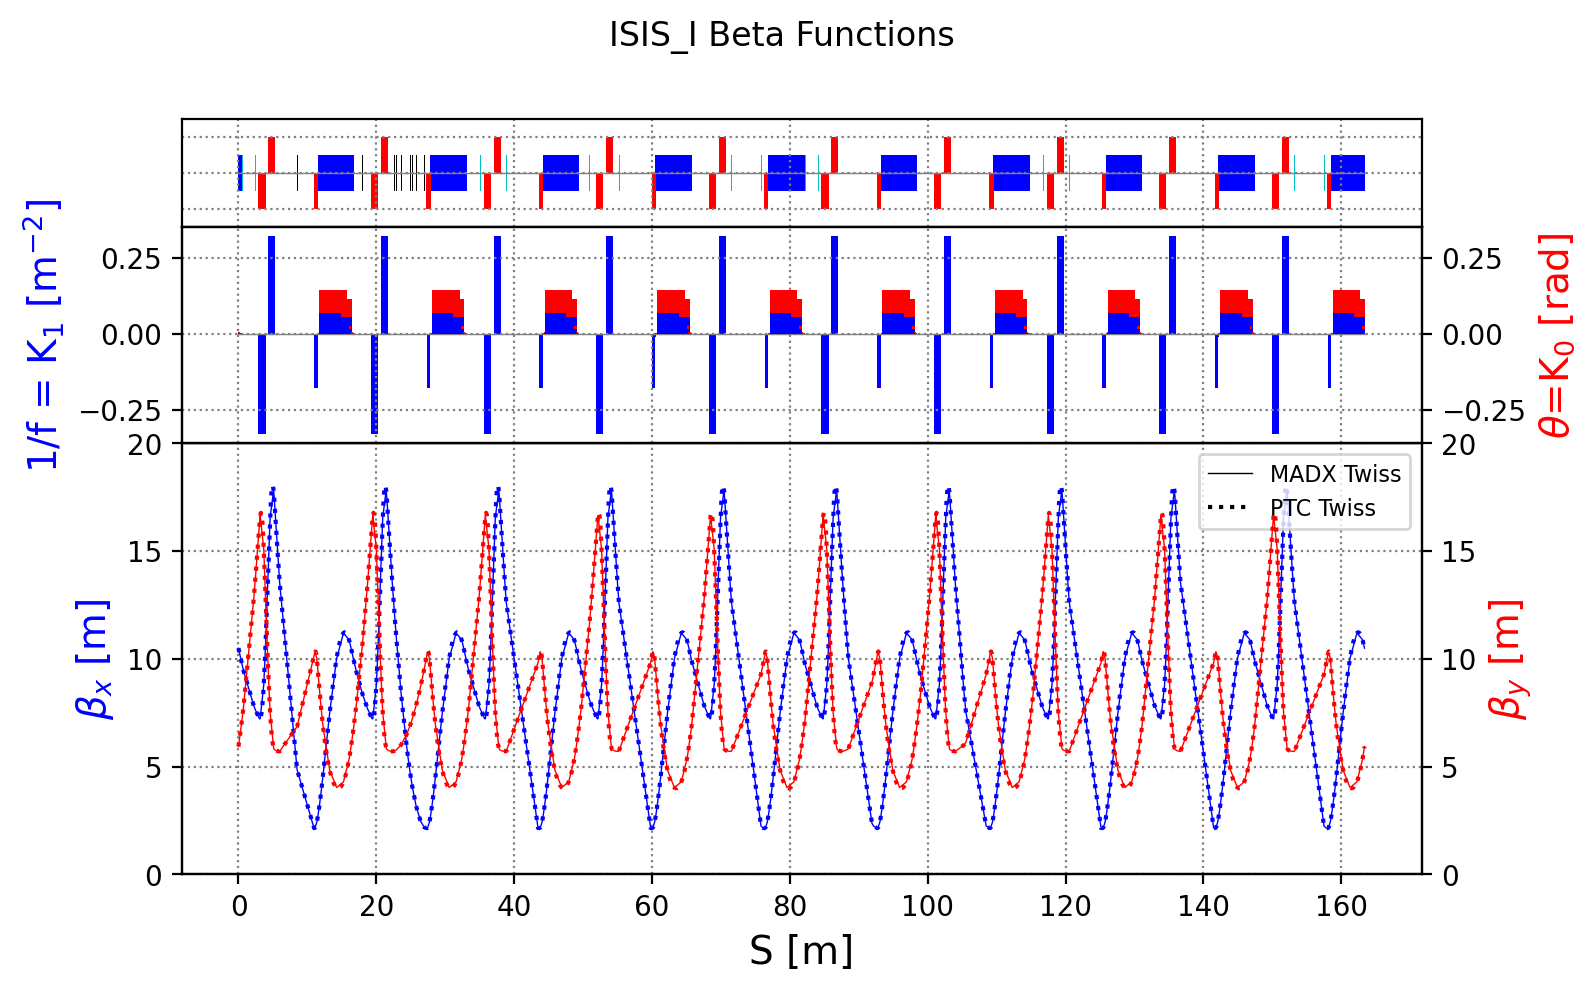

In [20]:
case_label = 'Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=3, height_ratios=[1,2,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[2,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)
ax4 = fig1.add_subplot(gs[1,0], sharex=ax1)

tit = main_label+ ' ' + case_label
fig1.suptitle(tit);

plot_lattice_elements(ax3,ptc_twiss_file)
plot_lattice_element_strengths(ax4, ptc_twiss_file, quads=True, dipoles=True)

ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')
ax4.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)

legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=1)

savename = save_folder + 'ISIS_I_Beta_Functions.png'
plt.savefig(savename)

plot_lattice_elements for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m
plot_lattice_element_strengths for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


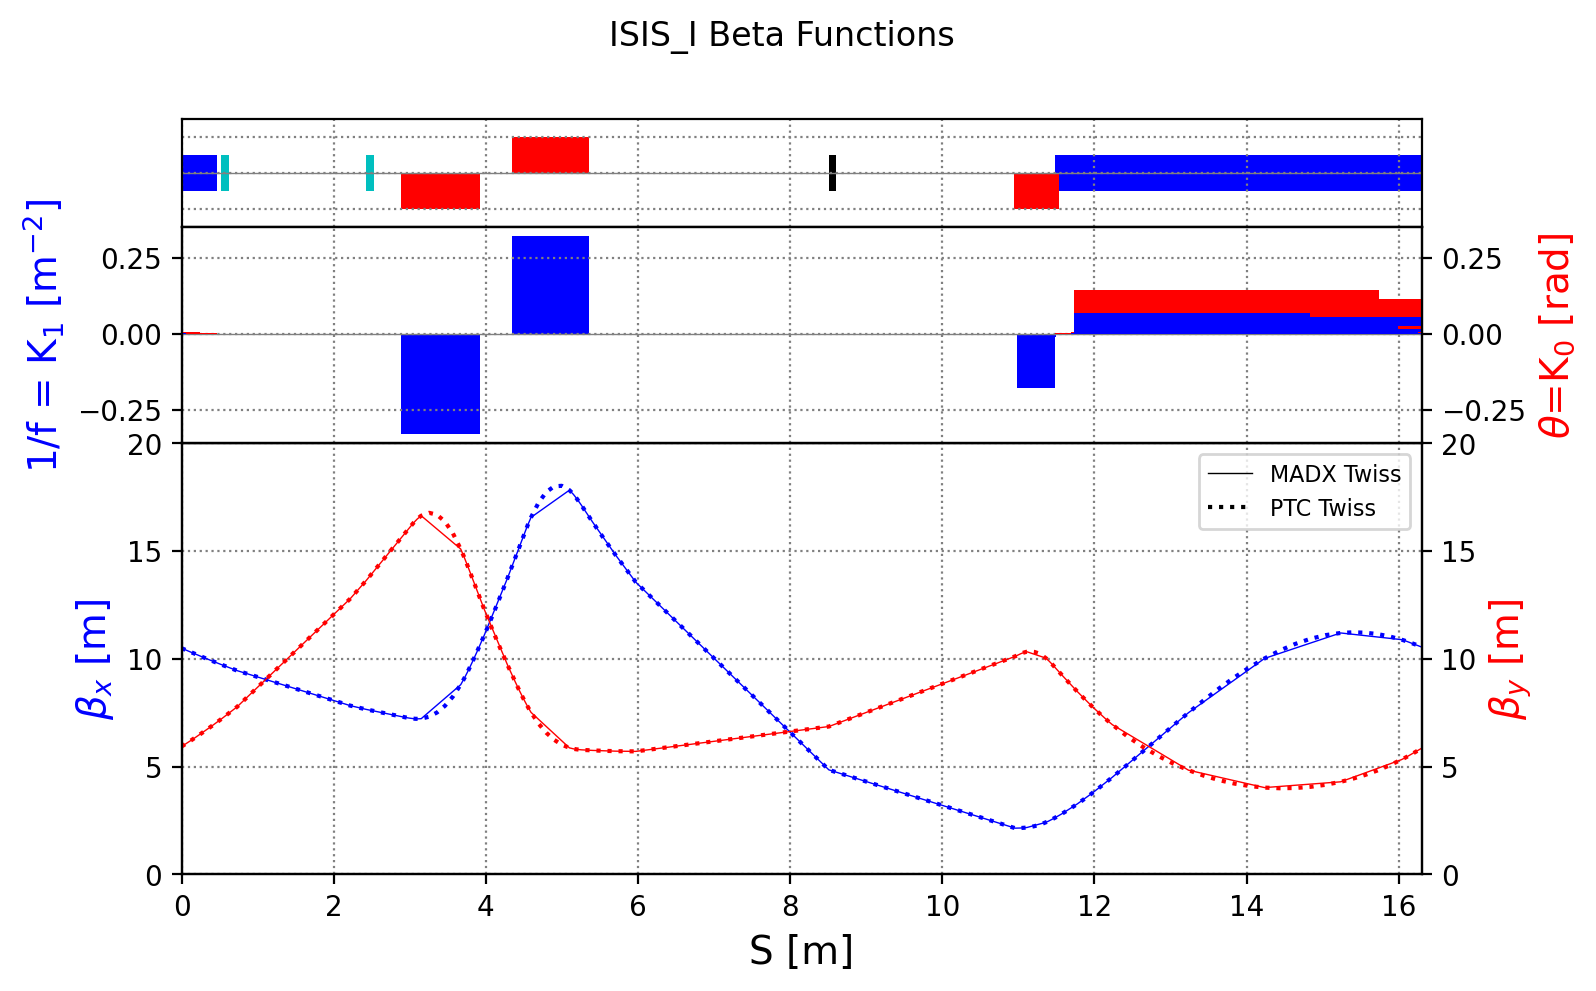

In [21]:
case_label = 'Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=3, height_ratios=[1,2,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[2,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)
ax4 = fig1.add_subplot(gs[1,0], sharex=ax1)

tit = main_label+ ' ' + case_label
fig1.suptitle(tit);

plot_lattice_elements(ax3,ptc_twiss_file)
plot_lattice_element_strengths(ax4, ptc_twiss_file, quads=True, dipoles=True)

ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')
ax4.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax1.set_xlim(0,16.3)

legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=1)

savename = save_folder + 'ISIS_I_Beta_Functions_zoom.png'
plt.savefig(savename)

plot_lattice_elements for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m
plot_lattice_element_strengths for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


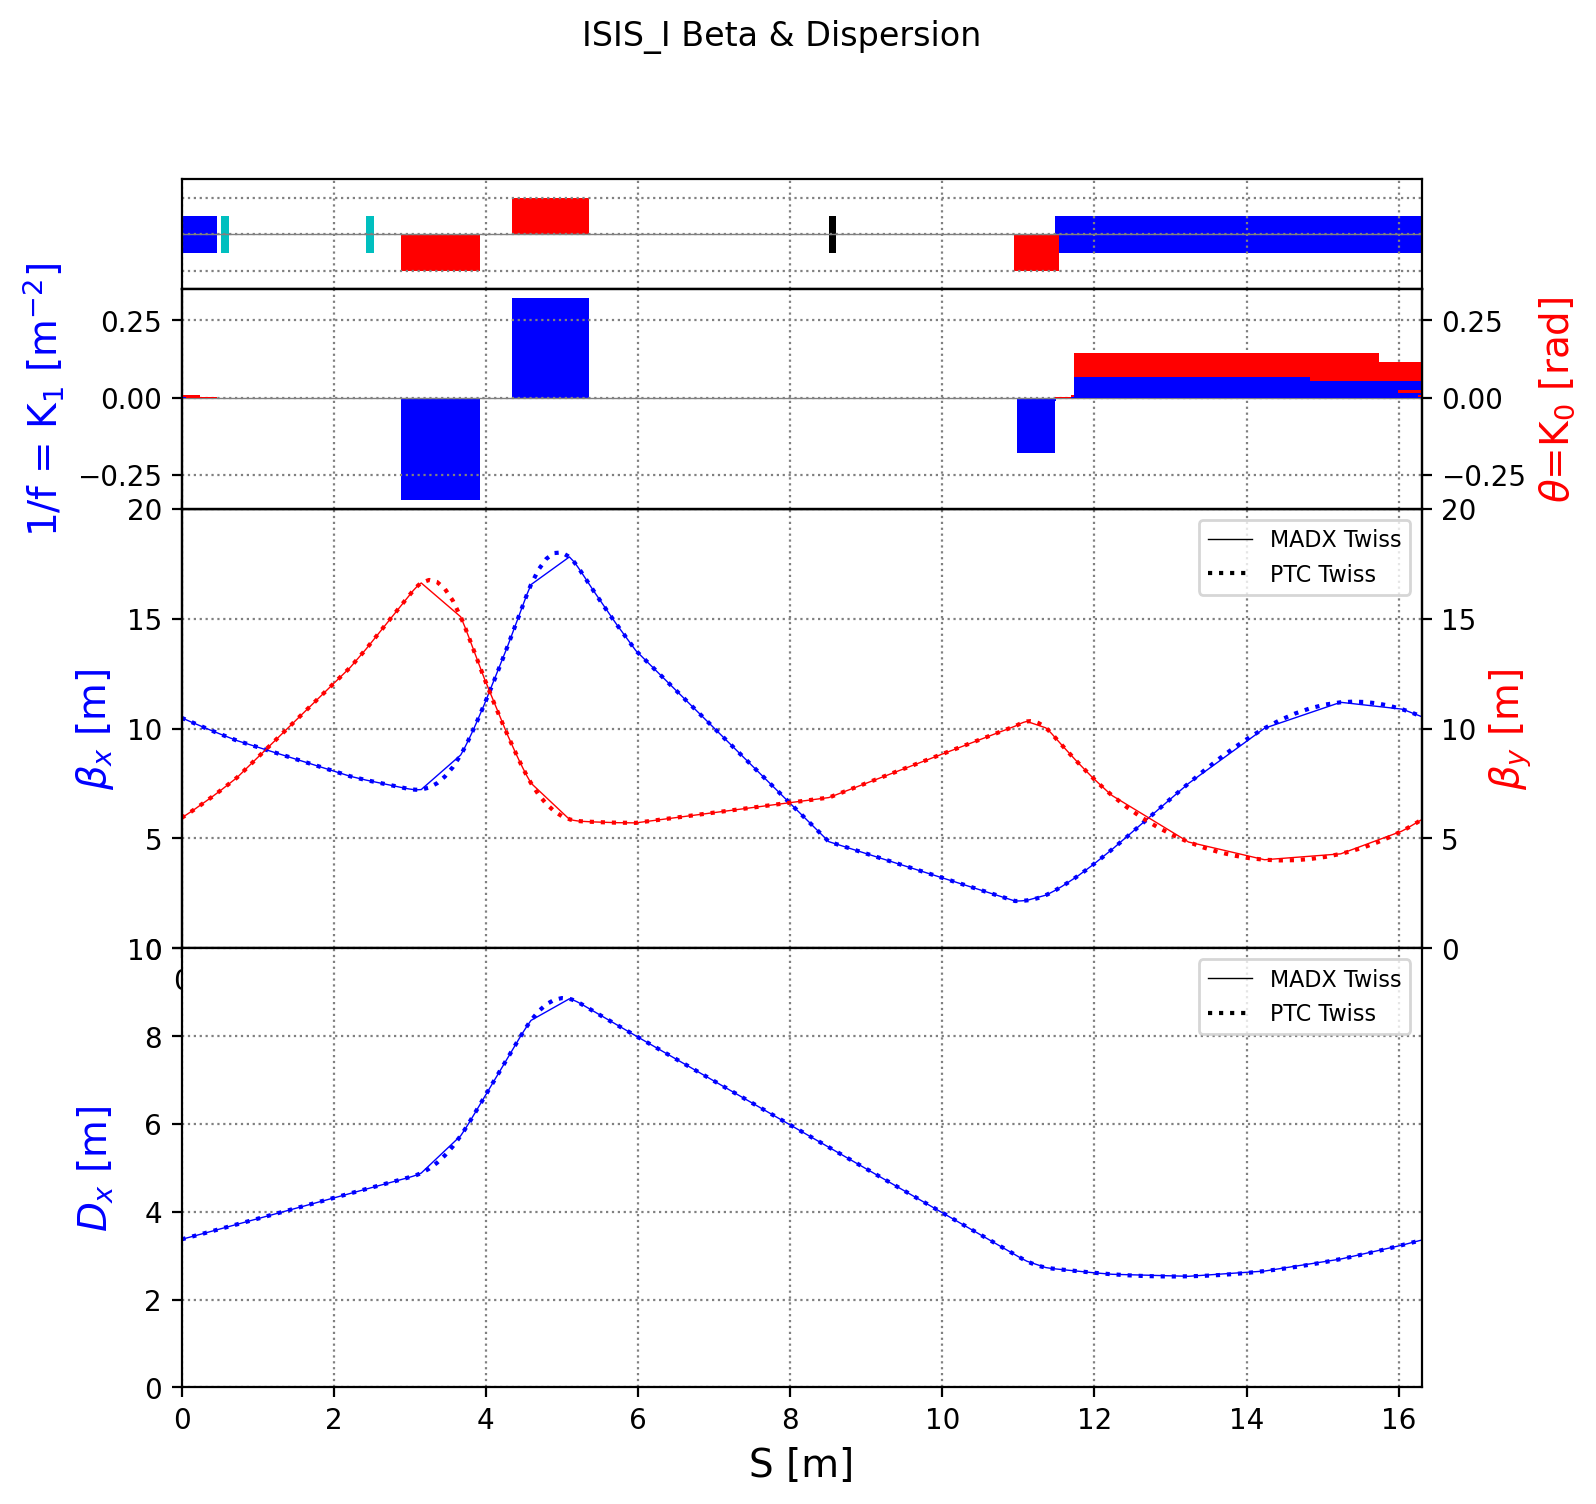

In [22]:
case_label = 'Beta & Dispersion'

# Make Figure and gridspec for multiplot layout control
fig1 = plt.figure(facecolor='w', edgecolor='k', figsize=[8.0, 8.0])
gs = fig1.add_gridspec(ncols=1,nrows=4, height_ratios=[1,2,4,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[2,0])             # Beta functions horizontal
ax2 = ax1.twinx()                           # Beta functions vertical
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1) # Layout diagram
ax4 = fig1.add_subplot(gs[1,0], sharex=ax1) # quad/dipole strengths
ax5 = fig1.add_subplot(gs[3,0], sharex=ax1) # dispersion

tit = main_label+ ' ' + case_label
fig1.suptitle(tit);

# Function to add accelerator block diagram
plot_lattice_elements(ax3,ptc_twiss_file)
plot_lattice_element_strengths(ax4, ptc_twiss_file, quads=True, dipoles=True)

# Plots from PTC/MADX Twiss
ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')
ax5.plot(madx_twiss.s, madx_twiss.dx, color='b', lw=0.5)
ax5.plot(ptc_twiss.s, ptc_twiss.disp1/beta_rel, color='b', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')
ax5.set_xlabel('S [m]')
ax5.set_ylabel(r'$D_x$ [m]', color='b')   

# Add grids
ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')
ax4.grid(which='major', ls=':', color='grey')
ax5.grid(which='both', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax5.set_ylim(0,10)
ax1.set_xlim(0,16.3)

# Suppress middle plot x ticks and labels
ax1.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')     
ax2.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')     

# Custom legend
legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]
ax1.legend(handles=legend_elements, loc=1)
ax5.legend(handles=legend_elements, loc=1)

# Save
savename = save_folder + 'ISIS_I_Beta_Dispersion_zoom.png'
plt.savefig(savename)

# Next we will use the MAD-X matching function to match the beta functions at certain elements to the measurements provided 

SP0_QTF, betx=15.82, bety=5.35;   
SP1_QTF, betx=15.69, bety=6.11;
SP2_QTF, betx=16.13, bety=5.37;
SP3_QTF, betx=16.17, bety=5.18;
SP4_QTF, betx=16.29, bety=5.80;
SP5_QTF, betx=16.19, bety=6.01;
SP6_QTF, betx=15.75, bety=5.53;
SP7_QTF, betx=15.94, bety=5.49;
SP8_QTF, betx=15.29, bety=6.08;
SP9_QTF, betx=15.81, bety=6.17;
SP0_QTD, betx=12.83, bety=10.19;
SP1_QTD, betx=12.61, bety=11.21;
SP2_QTD, betx=12.69, bety=10.34;
SP3_QTD, betx=12.94, bety=11.06;
SP4_QTD, betx=13.17, bety=11.41;
SP5_QTD, betx=12.65, bety=11.43;
SP6_QTD, betx=12.20, bety=10.51;
SP7_QTD, betx=12.71, bety=10.92;
SP8_QTD, betx=12.19, bety=12.00;
SP9_QTD, betx=12.66, bety=11.63; 

## Check elements in sequence
Check if there is an element with this name (sp0_qtd) in:
- Our MAD-X environment (global)
- Our MAD-X sequence 'synchrotron'

In [23]:
print('sp0_qtd' in madx.elements)
print('sp0_qtd' in madx.sequence.synchrotron.elements)

True
True


### Now let's see how the element is defined

In [24]:
quad_sp0_qtd = madx.elements.sp0_qtd
print(quad_sp0_qtd)

sp0_qtd: r0qtd, at=4.28525;


> **sp0_qtd** is an instance of **r0qtd**

In [25]:
quad_r0qtd = madx.elements.r0qtd
print(quad_r0qtd)

r0qtd: qtd, k1=0.00610063;


> **r0qtd** is an instance of **qtd** - as the magnet is identical in all superperiods (and should be powered symmetrically) it is only defined once

In [26]:
quad_qtd = madx.elements.qtd
print(quad_qtd)

qtd: quadrupole, l=0.307, k1=0.00610063;


> Now we know that **sp0_qtd** is an instance of **r0qtd** is an instance of **qtd**
>
> We can overwrite **sp0_qtd** or **r0qtd** to use a unique k1 variable which can be varied independently from the other quadrupoles 

## We can also check the expression definition for K1:

In [27]:
madx.elements.sp0_qtd.defs['k1'] # Element definition of k1 for sp0_qtd

'kqtd + her0qtd'

In [28]:
madx.elements.r0qtd.defs['k1'] # Element definition of k1 for r0qtd

'kqtd + her0qtd'

In [29]:
madx.elements.qtd.defs['k1'] # Element definition of k1 for qtd

0.00610063

In [30]:
madx.globals.defs.kqtd # Global definition of variable kqtd

0.00610063

In [31]:
madx.globals.defs.kqtf # Global definition of variable kqtd

-0.01155444

In [32]:
madx.globals.defs.her0qtd # Global definition of variable her0qtd (harmonic function)

'(a1*cos(hn1*(0/10)*2*pi))+(b1*sin(hn1*(0/10)*2*pi))'

In [33]:
madx.globals.her0qtd # Global value of variable her0qtd

0.0

# Redefine definition of K1 for all trim quadrupoles
## We should not override the harmonic function referred to as her0qtd in:

In [34]:
madx.elements.sp0_qtd.defs['k1'] # Element definition of k1 for sp0_qtd

'kqtd + her0qtd'

> **Approach:**
> > - For each quad, replace **kqtd** with an individual variable **kqtd_0** etc
> > - Set the initial value for each new variable to that of **kqtd_0 = kqtd**
> > - Match using individual **kqtd_i** variables
>

### 0. Check original values 

In [35]:
print(madx.elements.sp0_qtd.k1)
print(madx.elements.sp1_qtd.k1)
print(madx.elements.sp2_qtd.k1)
print(madx.elements.sp3_qtd.k1)
print(madx.elements.sp4_qtd.k1)
print(madx.elements.sp5_qtd.k1)
print(madx.elements.sp6_qtd.k1)
print(madx.elements.sp7_qtd.k1)
print(madx.elements.sp8_qtd.k1)
print(madx.elements.sp9_qtd.k1)

print(madx.elements.sp0_qtf.k1)
print(madx.elements.sp1_qtf.k1)
print(madx.elements.sp2_qtf.k1)
print(madx.elements.sp3_qtf.k1)
print(madx.elements.sp4_qtf.k1)
print(madx.elements.sp5_qtf.k1)
print(madx.elements.sp6_qtf.k1)
print(madx.elements.sp7_qtf.k1)
print(madx.elements.sp8_qtf.k1)
print(madx.elements.sp9_qtf.k1)

0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444


### 1. First we create the new variables and set initial values to zero

In [36]:
madx_str = '''
kqtd_0=0;
kqtd_1=0;
kqtd_2=0;
kqtd_3=0;
kqtd_4=0;
kqtd_5=0;
kqtd_6=0;
kqtd_7=0;
kqtd_8=0;
kqtd_9=0;
kqtf_0=0;
kqtf_1=0;
kqtf_2=0;
kqtf_3=0;
kqtf_4=0;
kqtf_5=0;
kqtf_6=0;
kqtf_7=0;
kqtf_8=0;
kqtf_9=0;
'''

madx.input(madx_str)

True

### 2. Next we set the new variables to the original value

In [37]:
madx.globals.kqtd_0 = madx.globals.defs.kqtd
madx.globals.kqtd_1 = madx.globals.defs.kqtd
madx.globals.kqtd_2 = madx.globals.defs.kqtd
madx.globals.kqtd_3 = madx.globals.defs.kqtd
madx.globals.kqtd_4 = madx.globals.defs.kqtd
madx.globals.kqtd_5 = madx.globals.defs.kqtd
madx.globals.kqtd_6 = madx.globals.defs.kqtd
madx.globals.kqtd_7 = madx.globals.defs.kqtd
madx.globals.kqtd_8 = madx.globals.defs.kqtd
madx.globals.kqtd_9 = madx.globals.defs.kqtd

madx.globals.kqtf_0 = madx.globals.defs.kqtf
madx.globals.kqtf_1 = madx.globals.defs.kqtf
madx.globals.kqtf_2 = madx.globals.defs.kqtf
madx.globals.kqtf_3 = madx.globals.defs.kqtf
madx.globals.kqtf_4 = madx.globals.defs.kqtf
madx.globals.kqtf_5 = madx.globals.defs.kqtf
madx.globals.kqtf_6 = madx.globals.defs.kqtf
madx.globals.kqtf_7 = madx.globals.defs.kqtf
madx.globals.kqtf_8 = madx.globals.defs.kqtf
madx.globals.kqtf_9 = madx.globals.defs.kqtf

### 3. Set element definitions of K1 to use new variables

In [38]:
print(madx.elements.sp0_qtd.defs['k1'])
print(madx.elements.sp1_qtd.defs['k1'])
print(madx.elements.sp2_qtd.defs['k1'])
print(madx.elements.sp3_qtd.defs['k1'])
print(madx.elements.sp4_qtd.defs['k1'])
print(madx.elements.sp5_qtd.defs['k1'])
print(madx.elements.sp6_qtd.defs['k1'])
print(madx.elements.sp7_qtd.defs['k1'])
print(madx.elements.sp8_qtd.defs['k1'])
print(madx.elements.sp9_qtd.defs['k1'])

print(madx.elements.sp0_qtf.defs['k1'])
print(madx.elements.sp1_qtf.defs['k1'])
print(madx.elements.sp2_qtf.defs['k1'])
print(madx.elements.sp3_qtf.defs['k1'])
print(madx.elements.sp4_qtf.defs['k1'])
print(madx.elements.sp5_qtf.defs['k1'])
print(madx.elements.sp6_qtf.defs['k1'])
print(madx.elements.sp7_qtf.defs['k1'])
print(madx.elements.sp8_qtf.defs['k1'])
print(madx.elements.sp9_qtf.defs['k1'])

kqtd + her0qtd
kqtd + her1qtd
kqtd + her2qtd
kqtd + her3qtd
kqtd + her4qtd
kqtd + her5qtd
kqtd + her6qtd
kqtd + her7qtd
kqtd + her8qtd
kqtd + her9qtd
kqtf + her0qtf
kqtf + her1qtf
kqtf + her2qtf
kqtf + her3qtf
kqtf + her4qtf
kqtf + her5qtf
kqtf + her6qtf
kqtf + her7qtf
kqtf + her8qtf
kqtf + her9qtf


In [39]:
madx.elements.sp0_qtd.k1 = 'kqtd_0 + her0qtd'
madx.elements.sp1_qtd.k1 = 'kqtd_1 + her1qtd'
madx.elements.sp2_qtd.k1 = 'kqtd_2 + her2qtd'
madx.elements.sp3_qtd.k1 = 'kqtd_3 + her3qtd'
madx.elements.sp4_qtd.k1 = 'kqtd_4 + her4qtd'
madx.elements.sp5_qtd.k1 = 'kqtd_5 + her5qtd'
madx.elements.sp6_qtd.k1 = 'kqtd_6 + her6qtd'
madx.elements.sp7_qtd.k1 = 'kqtd_7 + her7qtd'
madx.elements.sp8_qtd.k1 = 'kqtd_8 + her8qtd'
madx.elements.sp9_qtd.k1 = 'kqtd_9 + her9qtd'
madx.elements.sp0_qtf.k1 = 'kqtf_0 + her0qtf'
madx.elements.sp1_qtf.k1 = 'kqtf_1 + her1qtf'
madx.elements.sp2_qtf.k1 = 'kqtf_2 + her2qtf'
madx.elements.sp3_qtf.k1 = 'kqtf_3 + her3qtf'
madx.elements.sp4_qtf.k1 = 'kqtf_4 + her4qtf'
madx.elements.sp5_qtf.k1 = 'kqtf_5 + her5qtf'
madx.elements.sp6_qtf.k1 = 'kqtf_6 + her6qtf'
madx.elements.sp7_qtf.k1 = 'kqtf_7 + her7qtf'
madx.elements.sp8_qtf.k1 = 'kqtf_8 + her8qtf'
madx.elements.sp9_qtf.k1 = 'kqtf_9 + her9qtf'

In [40]:
print(madx.elements.sp0_qtd.defs['k1'])
print(madx.elements.sp1_qtd.defs['k1'])
print(madx.elements.sp2_qtd.defs['k1'])
print(madx.elements.sp3_qtd.defs['k1'])
print(madx.elements.sp4_qtd.defs['k1'])
print(madx.elements.sp5_qtd.defs['k1'])
print(madx.elements.sp6_qtd.defs['k1'])
print(madx.elements.sp7_qtd.defs['k1'])
print(madx.elements.sp8_qtd.defs['k1'])
print(madx.elements.sp9_qtd.defs['k1'])

print(madx.elements.sp0_qtf.defs['k1'])
print(madx.elements.sp1_qtf.defs['k1'])
print(madx.elements.sp2_qtf.defs['k1'])
print(madx.elements.sp3_qtf.defs['k1'])
print(madx.elements.sp4_qtf.defs['k1'])
print(madx.elements.sp5_qtf.defs['k1'])
print(madx.elements.sp6_qtf.defs['k1'])
print(madx.elements.sp7_qtf.defs['k1'])
print(madx.elements.sp8_qtf.defs['k1'])
print(madx.elements.sp9_qtf.defs['k1'])

kqtd_0 + her0qtd
kqtd_1 + her1qtd
kqtd_2 + her2qtd
kqtd_3 + her3qtd
kqtd_4 + her4qtd
kqtd_5 + her5qtd
kqtd_6 + her6qtd
kqtd_7 + her7qtd
kqtd_8 + her8qtd
kqtd_9 + her9qtd
kqtf_0 + her0qtf
kqtf_1 + her1qtf
kqtf_2 + her2qtf
kqtf_3 + her3qtf
kqtf_4 + her4qtf
kqtf_5 + her5qtf
kqtf_6 + her6qtf
kqtf_7 + her7qtf
kqtf_8 + her8qtf
kqtf_9 + her9qtf


### 4. Check values unchanged

In [41]:
print(madx.elements.sp0_qtd.k1)
print(madx.elements.sp1_qtd.k1)
print(madx.elements.sp2_qtd.k1)
print(madx.elements.sp3_qtd.k1)
print(madx.elements.sp4_qtd.k1)
print(madx.elements.sp5_qtd.k1)
print(madx.elements.sp6_qtd.k1)
print(madx.elements.sp7_qtd.k1)
print(madx.elements.sp8_qtd.k1)
print(madx.elements.sp9_qtd.k1)

print(madx.elements.sp0_qtf.k1)
print(madx.elements.sp1_qtf.k1)
print(madx.elements.sp2_qtf.k1)
print(madx.elements.sp3_qtf.k1)
print(madx.elements.sp4_qtf.k1)
print(madx.elements.sp5_qtf.k1)
print(madx.elements.sp6_qtf.k1)
print(madx.elements.sp7_qtf.k1)
print(madx.elements.sp8_qtf.k1)
print(madx.elements.sp9_qtf.k1)

0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444


### 5. Match

In [42]:
madx.globals.kqtd_0

0.00610063

### MAD-X Match command
>- **sequence**: MADX sequence to be matched
>- **constraints**: 
>    - **range**: elements to be varied
>    - **\<variables\>**: individual constraints e.g. betx=10.0, bety=12.0
>- **vary**: variables to vary **(note these should be in terms of the sequence e.g. sp0_qtd->k1)**
>- **method**: see madx manual for explanation, options: lmdif, migrad, simplex, jacobian
>     - **LMDIF**:
>         - **calls**: integer max number of calls to penalty function (default 1000)
>         - **tolerance**: desired tolerance for the minimum (default 1E-6)
>     - **MIGRAD**:
>         - **calls**: integer max number of calls to penalty function (default 1000)
>         - **tolerance**: desired tolerance for the minimum (default 1E-6)
>         - **strategy**: see MADX manual (default 1)
>     - **SIMPLEX**:
>         - **calls**: integer max number of calls to penalty function (default 1000)
>         - **tolerance**: desired tolerance for the minimum (default 1E-6)
>     - **JACOBIAN**:
>         - **calls**: integer max number of calls to penalty function (default 1000)
>         - **tolerance**: desired tolerance for the minimum (default 1E-6)
>         - **strategy**: see MADX manual (default 3)
>         - **repeat**: number of calls to Jacobian routine (default 1)
>         - **cool**: see MADX manual 
>         - **balance**: see MADX manual 
>         - **random**: see MADX manual 

### Test of matching using 2 constraints

In [43]:
#madx.match? # <- for more info run this

In [44]:
test=False
if test:
    madx.match(sequence='synchrotron',
          constraints=[dict(range='sp0_qtf',betx=15.82,bety=5.35)],
          #vary=['sp0_qtd->k1']) 
          vary=['sp0_qtd->k1','sp0_qtf->k1']) 
          #method=['lmdif'])
          #method=['lmdif',{'calls'=1000,'tolerance'=1.0e-20}]) #doesn't seem to work?

#### Print initial k1 values

In [45]:
print(madx.elements.sp0_qtd.k1)
print(madx.elements.sp1_qtd.k1)
print(madx.elements.sp2_qtd.k1)
print(madx.elements.sp3_qtd.k1)
print(madx.elements.sp4_qtd.k1)
print(madx.elements.sp5_qtd.k1)
print(madx.elements.sp6_qtd.k1)
print(madx.elements.sp7_qtd.k1)
print(madx.elements.sp8_qtd.k1)
print(madx.elements.sp9_qtd.k1)

print(madx.elements.sp0_qtf.k1)
print(madx.elements.sp1_qtf.k1)
print(madx.elements.sp2_qtf.k1)
print(madx.elements.sp3_qtf.k1)
print(madx.elements.sp4_qtf.k1)
print(madx.elements.sp5_qtf.k1)
print(madx.elements.sp6_qtf.k1)
print(madx.elements.sp7_qtf.k1)
print(madx.elements.sp8_qtf.k1)
print(madx.elements.sp9_qtf.k1)

0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
0.00610063
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444
-0.01155444


### Perform full matching with Hayley's measurements

In [46]:
madx.match(sequence='synchrotron',
          constraints=[dict(range='sp0_qtf',betx=15.82,bety=5.35),
                       dict(range='sp1_qtf',betx=15.69,bety=6.11),
                       dict(range='sp2_qtf',betx=16.13,bety=5.37),
                       dict(range='sp3_qtf',betx=16.17,bety=5.18),
                       dict(range='sp4_qtf',betx=16.29,bety=5.80),
                       dict(range='sp5_qtf',betx=16.19,bety=6.01),
                       dict(range='sp6_qtf',betx=15.75,bety=5.53),
                       dict(range='sp7_qtf',betx=15.94,bety=5.49),
                       dict(range='sp8_qtf',betx=15.29,bety=6.08),
                       dict(range='sp9_qtf',betx=15.81,bety=6.17),
                       dict(range='sp0_qtd',betx=12.83,bety=10.19),
                       dict(range='sp1_qtd',betx=12.61,bety=11.21),
                       dict(range='sp2_qtd',betx=12.69,bety=10.34),
                       dict(range='sp3_qtd',betx=12.94,bety=11.06),
                       dict(range='sp4_qtd',betx=13.17,bety=11.41),
                       dict(range='sp5_qtd',betx=12.65,bety=11.43),
                       dict(range='sp6_qtd',betx=12.20,bety=10.51),
                       dict(range='sp7_qtd',betx=12.71,bety=10.92),
                       dict(range='sp8_qtd',betx=12.19,bety=12.00),
                       dict(range='sp9_qtd',betx=12.66,bety=11.63)],
          vary=['sp0_qtd->k1', 'sp0_qtf->k1',
                'sp1_qtd->k1', 'sp1_qtf->k1',
                'sp2_qtd->k1', 'sp2_qtf->k1',
                'sp3_qtd->k1', 'sp3_qtf->k1',
                'sp4_qtd->k1', 'sp4_qtf->k1',
                'sp5_qtd->k1', 'sp5_qtf->k1',
                'sp6_qtd->k1', 'sp6_qtf->k1',
                'sp7_qtd->k1', 'sp7_qtf->k1',
                'sp8_qtd->k1', 'sp8_qtf->k1',
                'sp9_qtd->k1', 'sp9_qtf->k1',
               ]) 
          #method=['lmdif'])
          #method=['lmdif',{'calls'=1000,'tolerance'=1.0e-20}]) #doesn't seem to work?

{'sp0_qtd->k1': -0.12287978623313757,
 'sp0_qtf->k1': 0.0843117430535349,
 'sp1_qtd->k1': -0.03579478641371773,
 'sp1_qtf->k1': 0.029248620729842106,
 'sp2_qtd->k1': -0.1053129408014202,
 'sp2_qtf->k1': 0.06990043884264041,
 'sp3_qtd->k1': -0.08516867418340825,
 'sp3_qtf->k1': 0.06565375057364745,
 'sp4_qtd->k1': -0.08046122079722312,
 'sp4_qtf->k1': 0.0521995489043234,
 'sp5_qtd->k1': -0.08109270284294041,
 'sp5_qtf->k1': 0.05334305058616147,
 'sp6_qtd->k1': -0.11170291273307248,
 'sp6_qtf->k1': 0.0868520879497796,
 'sp7_qtd->k1': -0.09308979687139904,
 'sp7_qtf->k1': 0.052774560106717223,
 'sp8_qtd->k1': -0.08587602551349462,
 'sp8_qtf->k1': 0.07034977024401873,
 'sp9_qtd->k1': -0.07777834960136305,
 'sp9_qtf->k1': 0.04557584954871736}

#### Print matched k1 values

In [47]:
print(madx.elements.sp0_qtd.k1)
print(madx.elements.sp1_qtd.k1)
print(madx.elements.sp2_qtd.k1)
print(madx.elements.sp3_qtd.k1)
print(madx.elements.sp4_qtd.k1)
print(madx.elements.sp5_qtd.k1)
print(madx.elements.sp6_qtd.k1)
print(madx.elements.sp7_qtd.k1)
print(madx.elements.sp8_qtd.k1)
print(madx.elements.sp9_qtd.k1)

print(madx.elements.sp0_qtf.k1)
print(madx.elements.sp1_qtf.k1)
print(madx.elements.sp2_qtf.k1)
print(madx.elements.sp3_qtf.k1)
print(madx.elements.sp4_qtf.k1)
print(madx.elements.sp5_qtf.k1)
print(madx.elements.sp6_qtf.k1)
print(madx.elements.sp7_qtf.k1)
print(madx.elements.sp8_qtf.k1)
print(madx.elements.sp9_qtf.k1)

-0.12287978623313757
-0.03579478641371773
-0.1053129408014202
-0.08516867418340825
-0.08046122079722312
-0.08109270284294041
-0.11170291273307248
-0.09308979687139904
-0.08587602551349462
-0.07777834960136305
0.0843117430535349
0.029248620729842106
0.06990043884264041
0.06565375057364745
0.0521995489043234
0.05334305058616147
0.0868520879497796
0.052774560106717223
0.07034977024401873
0.04557584954871736


### 6. Perform a Twiss (both MADX and PTC) to check new optics

In [48]:
madx.input('SELECT,flag=TWISS,COLUMN=keyword, name, s, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, l, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
madx_twiss_matched = madx.twiss(sequence='synchrotron', file='isis_twiss_matched.tfs')

In [49]:
madx.input('ptc_create_universe')
madx.input('ptc_create_layout, time=false,model=2, method=6, nst=5, exact=true')
madx.input('ptc_twiss, closed_orbit, icase=56, no=4, slice_magnets')
madx.input('ptc_end')
madx.input('exec, write_ptc_twiss(\'isis_ptc_twiss_matched.tfs\');')
ptc_twiss_matched = madx.table['ptc_twiss']

###  7. Plot optics difference

plot_lattice_elements for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m
plot_lattice_element_strengths for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m
plot_lattice_element_strengths for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


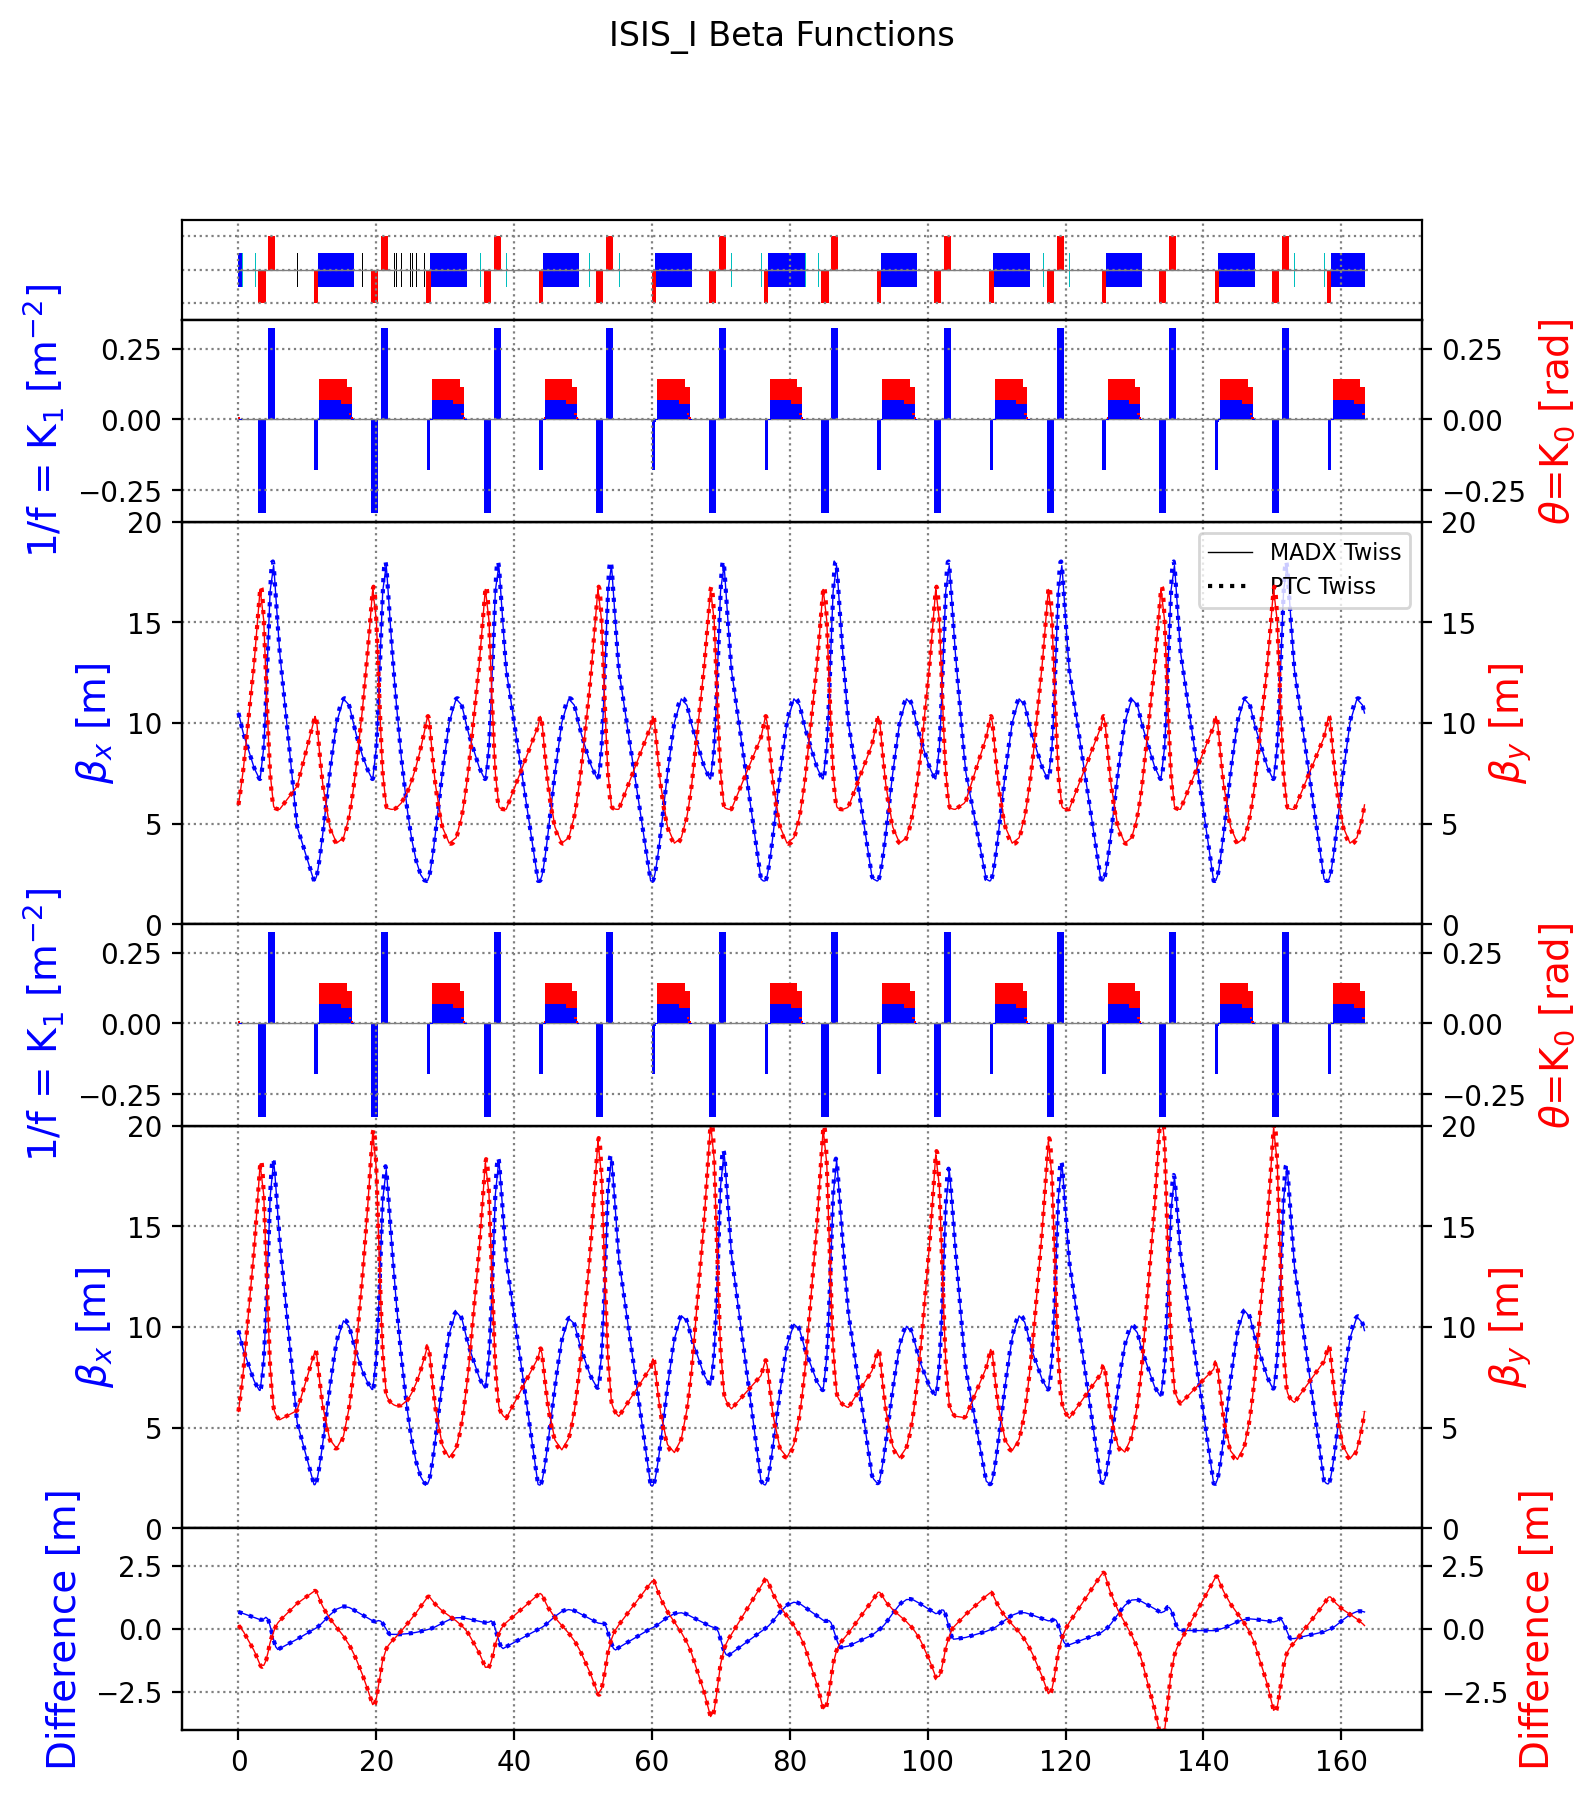

In [50]:
case_label = 'Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k', figsize=[8,10])
gs = fig1.add_gridspec(ncols=1,nrows=6, height_ratios=[1,2,4,2,4,2])
gs.update(wspace=0.025, hspace=0.)

tit = main_label+ ' ' + case_label
fig1.suptitle(tit);
                                            # ORIGINAL                    
ax1 = fig1.add_subplot(gs[2,0])             # Beta x
ax2 = ax1.twinx()                           # Beta y
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1) # Layout
ax4 = fig1.add_subplot(gs[1,0], sharex=ax1) # Strengths
                                            # MATCHED to measurements
ax5 = fig1.add_subplot(gs[4,0], sharex=ax1) # Beta x
ax6 = ax5.twinx()                           # Beta y
ax7 = fig1.add_subplot(gs[3,0], sharex=ax1) # Strengths
ax8 = fig1.add_subplot(gs[5,0], sharex=ax1) # Difference in beta x
ax9 = ax8.twinx()                           # Difference in beta y 



plot_lattice_elements(ax3,ptc_twiss_file)
plot_lattice_element_strengths(ax4, ptc_twiss_file, quads=True, dipoles=True)

ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')

ax5.plot(madx_twiss_matched.s, madx_twiss_matched.betx, color='b', lw=0.5)
ax5.plot(ptc_twiss_matched.s, ptc_twiss_matched.betx, color='b', ls=':')
ax6.plot(madx_twiss_matched.s, madx_twiss_matched.bety, color='r', lw=0.5)
ax6.plot(ptc_twiss_matched.s, ptc_twiss_matched.bety, color='r', ls=':')
plot_lattice_element_strengths(ax7, ptc_twiss_file, quads=True, dipoles=True)

ax8.plot(madx_twiss.s, (madx_twiss.betx-madx_twiss_matched.betx), color='b', lw=0.5)
ax8.plot(ptc_twiss.s, (ptc_twiss.betx-ptc_twiss_matched.betx), color='b', ls=':')
ax9.plot(madx_twiss.s, (madx_twiss.bety-madx_twiss_matched.bety), color='r', lw=0.5)
ax9.plot(ptc_twiss.s, (ptc_twiss.bety-ptc_twiss_matched.bety), color='r', ls=':')


ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')
ax5.set_ylabel(r'$\beta_x$ [m]', color='b')
ax6.set_ylabel(r'$\beta_y$ [m]', color='r')

ax8.set_ylabel(r'Difference [m]', color='b')
ax9.set_ylabel(r'Difference [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')
ax4.grid(which='major', ls=':', color='grey')
ax5.grid(which='both', ls=':', color='grey')
ax7.grid(which='major', ls=':', color='grey')
ax8.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax5.set_ylim(0,20)
ax6.set_ylim(0,20)
ax8.set_ylim(-4,4)
ax9.set_ylim(-4,4)

legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]
ax1.legend(handles=legend_elements, loc=1)

savename = save_folder + 'ISIS_I_Beta_Functions_Matched.png'
plt.savefig(savename)

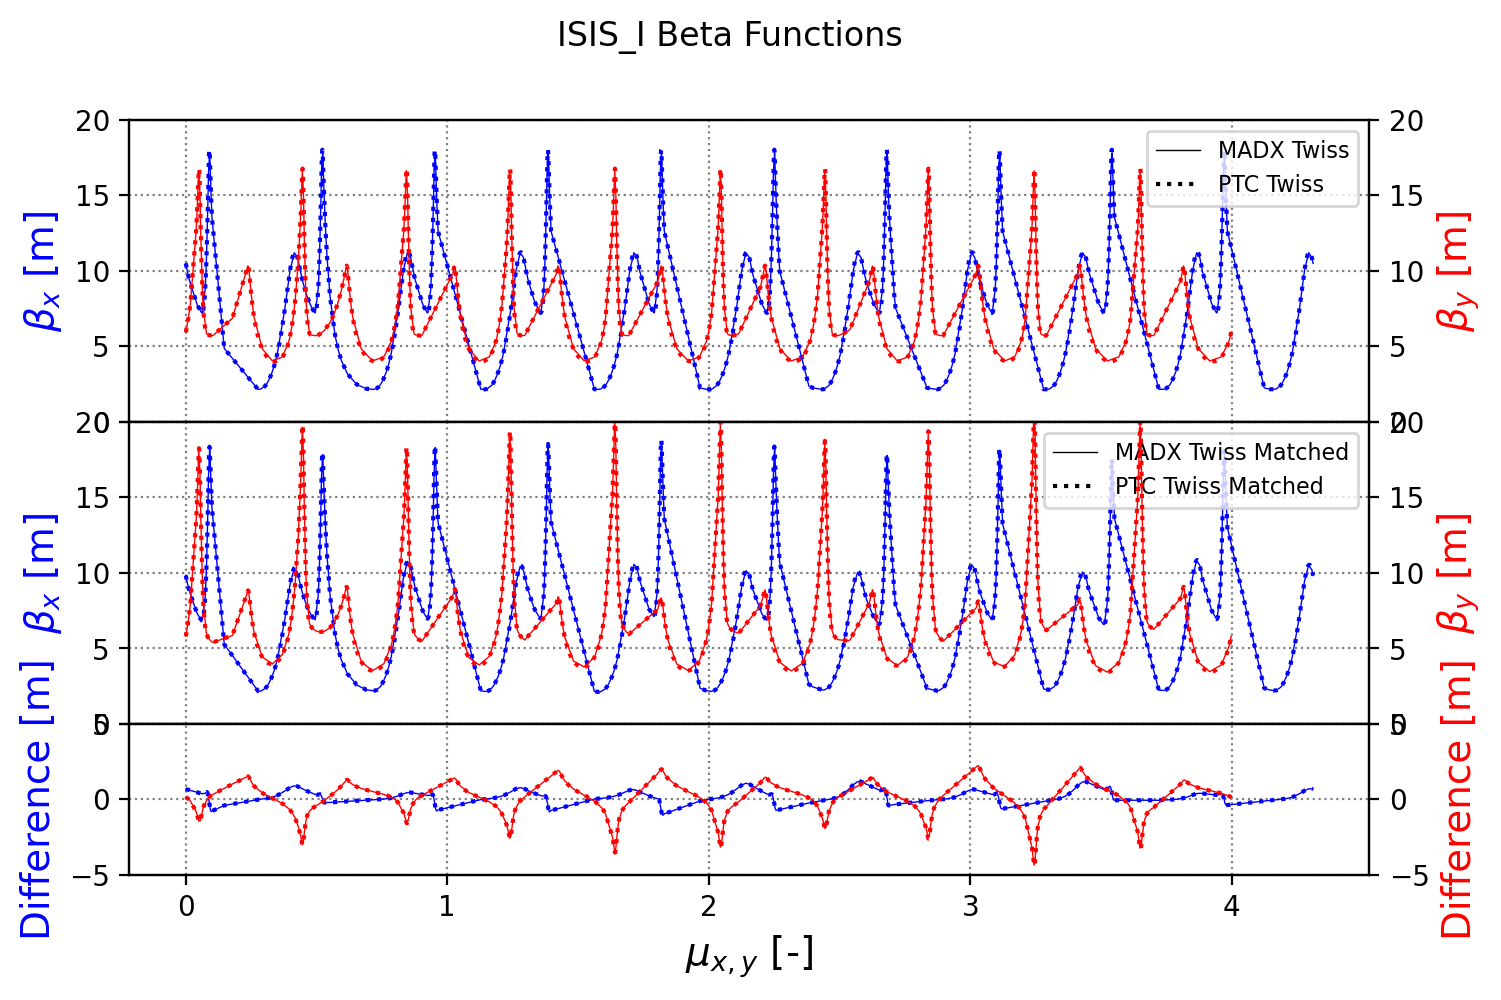

In [51]:
case_label = 'Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k', figsize=[8,5])
gs = fig1.add_gridspec(ncols=1,nrows=3, height_ratios=[4,4,2])
gs.update(wspace=0.025, hspace=0.)

tit = main_label+ ' ' + case_label
fig1.suptitle(tit);
                                            # ORIGINAL                    
ax1 = fig1.add_subplot(gs[0,0])             # Beta x
ax2 = ax1.twinx()                           # Beta y
                                            # MATCHED to measurements
ax3 = fig1.add_subplot(gs[1,0], sharex=ax1) # Beta x
ax4 = ax3.twinx()                           # Beta y
ax5 = fig1.add_subplot(gs[2,0], sharex=ax1) # Difference in beta x
ax6 = ax5.twinx()                           # Difference in beta y 

ax1.plot(madx_twiss.mux, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.mu1, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.muy, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.mu2, ptc_twiss.bety, color='r', ls=':')

ax3.plot(madx_twiss_matched.mux, madx_twiss_matched.betx, color='b', lw=0.5)
ax3.plot(ptc_twiss_matched.mu1, ptc_twiss_matched.betx, color='b', ls=':')
ax4.plot(madx_twiss_matched.muy, madx_twiss_matched.bety, color='r', lw=0.5)
ax4.plot(ptc_twiss_matched.mu2, ptc_twiss_matched.bety, color='r', ls=':')

ax5.plot(madx_twiss.mux, (madx_twiss.betx-madx_twiss_matched.betx), color='b', lw=0.5)
ax5.plot(ptc_twiss.mu1, (ptc_twiss.betx-ptc_twiss_matched.betx), color='b', ls=':')
ax6.plot(madx_twiss.muy, (madx_twiss.bety-madx_twiss_matched.bety), color='r', lw=0.5)
ax6.plot(ptc_twiss.mu2, (ptc_twiss.bety-ptc_twiss_matched.bety), color='r', ls=':')

ax5.set_xlabel(r'$\mu_{x,y}$ [-]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')
ax3.set_ylabel(r'$\beta_x$ [m]', color='b')
ax4.set_ylabel(r'$\beta_y$ [m]', color='r')
ax5.set_ylabel(r'Difference [m]', color='b')
ax6.set_ylabel(r'Difference [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='both', ls=':', color='grey')
ax5.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax3.set_ylim(0,20)
ax4.set_ylim(0,20)
ax5.set_ylim(-5,5)
ax6.set_ylim(-5,5)

legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]
ax1.legend(handles=legend_elements, loc=1)
legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss Matched'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss Matched')]
ax3.legend(handles=legend_elements, loc=1)

savename = save_folder + 'ISIS_I_Beta_Functions_Matched_mu.png'
plt.savefig(savename)

plot_lattice_elements for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m
plot_lattice_element_strengths for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m
plot_lattice_element_strengths for sequence  SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


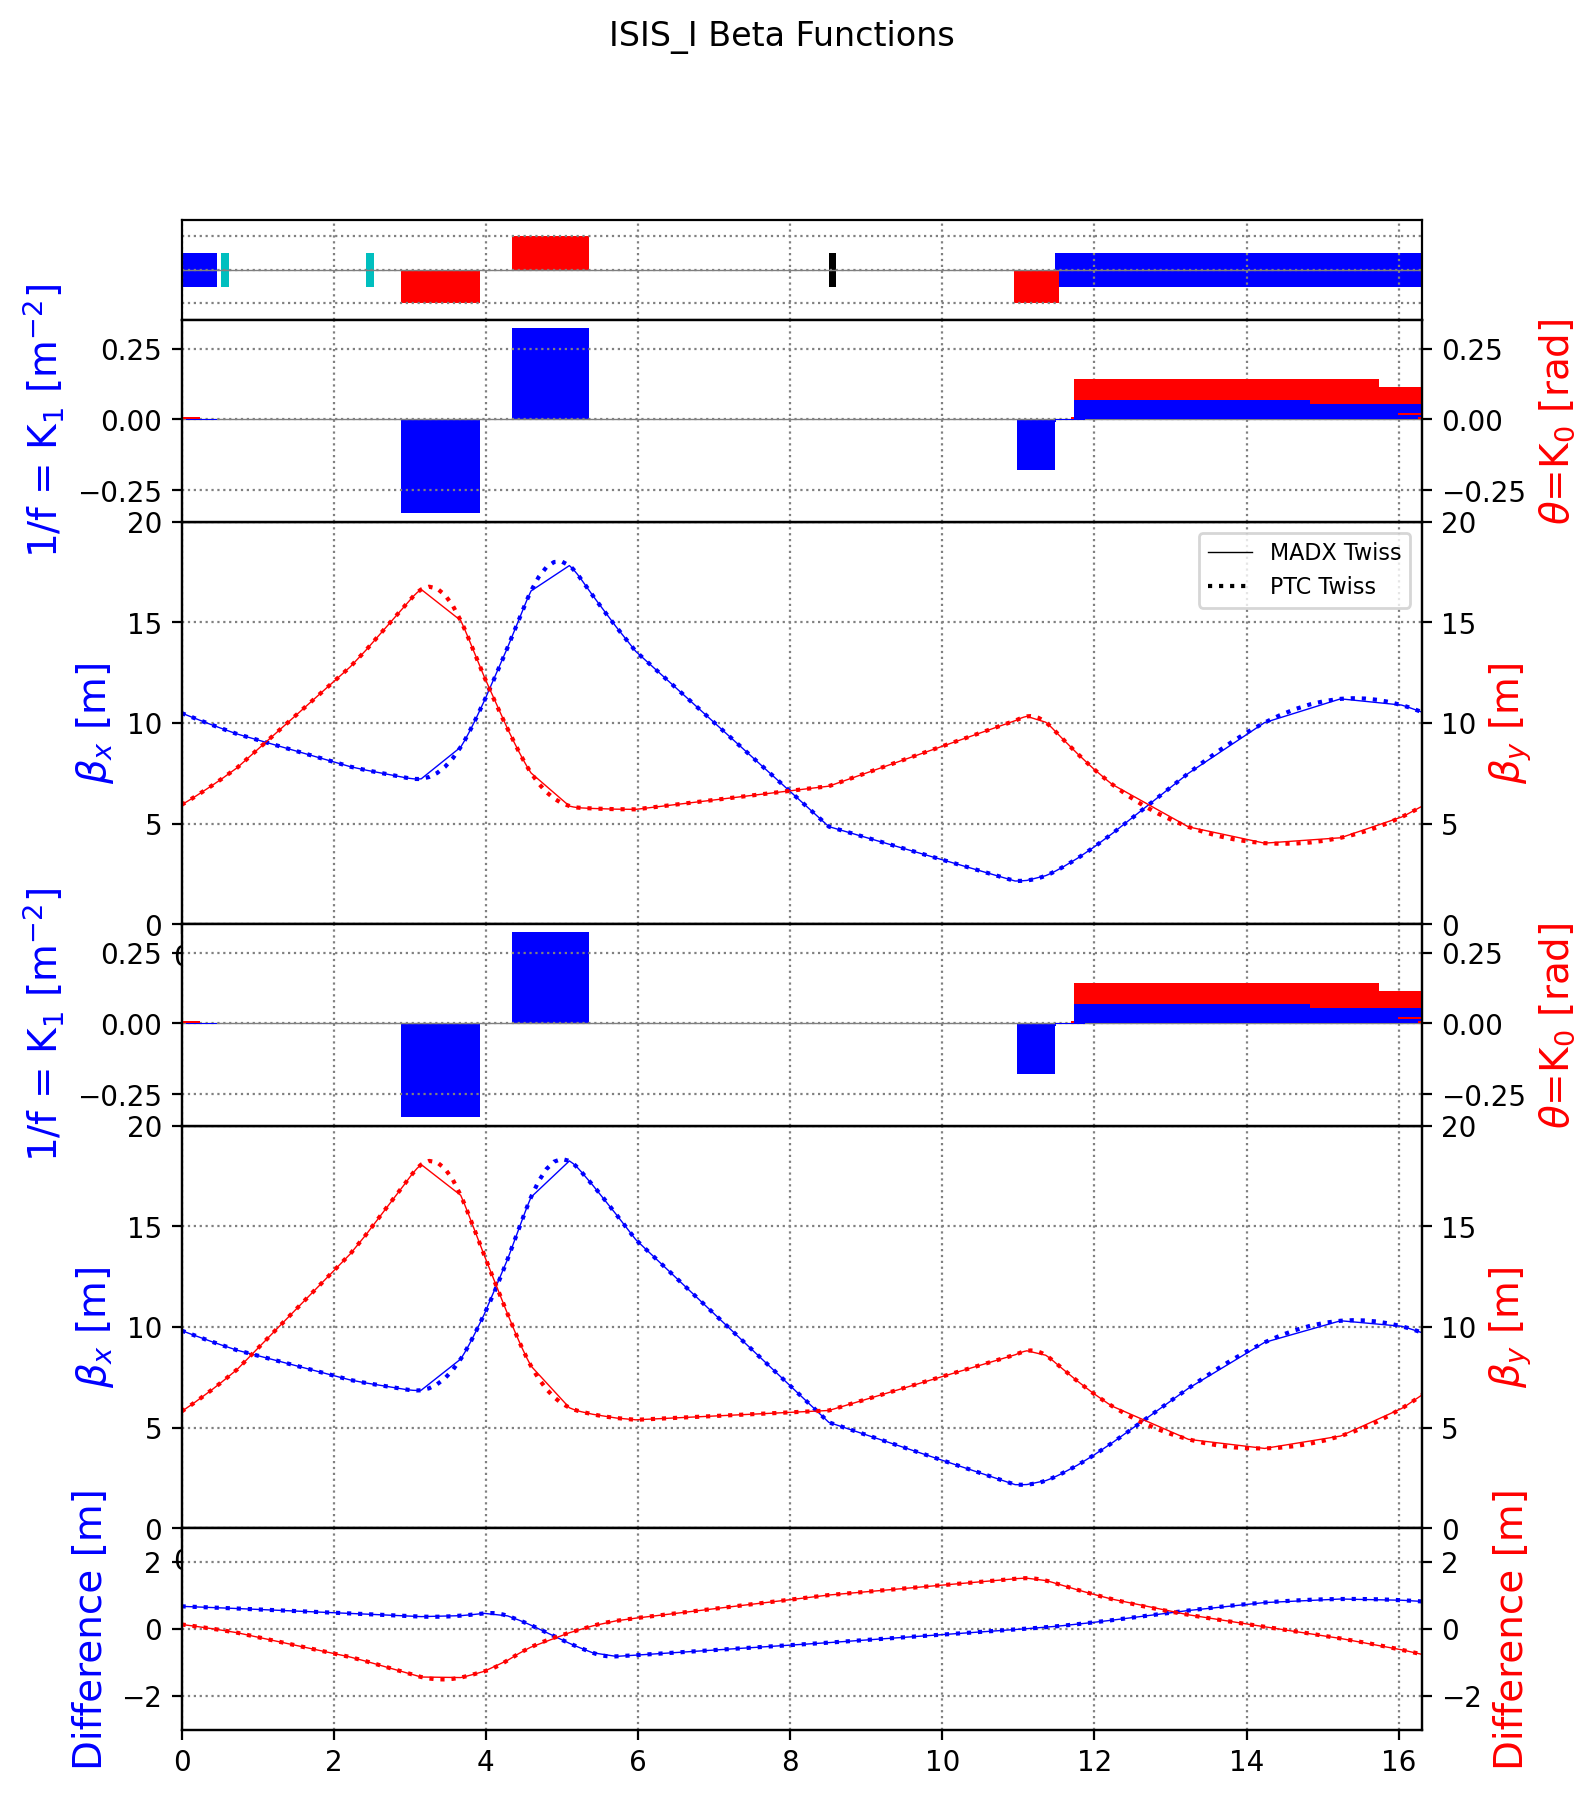

In [52]:
case_label = 'Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k', figsize=[8,10])
gs = fig1.add_gridspec(ncols=1,nrows=6, height_ratios=[1,2,4,2,4,2])
gs.update(wspace=0.025, hspace=0.)

tit = main_label+ ' ' + case_label
fig1.suptitle(tit);
                                            # ORIGINAL                    
ax1 = fig1.add_subplot(gs[2,0])             # Beta x
ax2 = ax1.twinx()                           # Beta y
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1) # Layout
ax4 = fig1.add_subplot(gs[1,0], sharex=ax1) # Strengths
                                            # MATCHED to measurements
ax5 = fig1.add_subplot(gs[4,0], sharex=ax1) # Beta x
ax6 = ax5.twinx()                           # Beta y
ax7 = fig1.add_subplot(gs[3,0], sharex=ax1) # Stregths
ax8 = fig1.add_subplot(gs[5,0], sharex=ax1) # Difference in beta x
ax9 = ax8.twinx()                           # Difference in beta y 

plot_lattice_elements(ax3,ptc_twiss_file)
plot_lattice_element_strengths(ax4, ptc_twiss_file, quads=True, dipoles=True)

ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')

ax5.plot(madx_twiss_matched.s, madx_twiss_matched.betx, color='b', lw=0.5)
ax5.plot(ptc_twiss_matched.s, ptc_twiss_matched.betx, color='b', ls=':')
ax6.plot(madx_twiss_matched.s, madx_twiss_matched.bety, color='r', lw=0.5)
ax6.plot(ptc_twiss_matched.s, ptc_twiss_matched.bety, color='r', ls=':')
plot_lattice_element_strengths(ax7, ptc_twiss_file, quads=True, dipoles=True)

ax8.plot(madx_twiss.s, (madx_twiss.betx-madx_twiss_matched.betx), color='b', lw=0.5)
ax8.plot(ptc_twiss.s, (ptc_twiss.betx-ptc_twiss_matched.betx), color='b', ls=':')
ax9.plot(madx_twiss.s, (madx_twiss.bety-madx_twiss_matched.bety), color='r', lw=0.5)
ax9.plot(ptc_twiss.s, (ptc_twiss.bety-ptc_twiss_matched.bety), color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')
ax5.set_ylabel(r'$\beta_x$ [m]', color='b')
ax6.set_ylabel(r'$\beta_y$ [m]', color='r')

ax8.set_ylabel(r'Difference [m]', color='b')
ax9.set_ylabel(r'Difference [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')
ax4.grid(which='major', ls=':', color='grey')
ax5.grid(which='both', ls=':', color='grey')
ax7.grid(which='major', ls=':', color='grey')
ax8.grid(which='major', ls=':', color='grey')

ax1.set_xlim(0,16.3)
ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax5.set_ylim(0,20)
ax6.set_ylim(0,20)
ax8.set_ylim(-3,3)
ax9.set_ylim(-3,3)

legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]
ax1.legend(handles=legend_elements, loc=1)

savename = save_folder + 'ISIS_I_Beta_Functions_Matched_zoom.png'
plt.savefig(savename)